# Analysis of MEV rewards in ETH2

This analysis is an adaptation of Pintail code from [this article](https://pintail.xyz/posts/beacon-chain-validator-rewards/) and added considerations using Flashbot data by by running an MEV-Geth node, querying the public [mev-blocks API](https://blocks.flashbots.net) and looking at data in the [public dashboard](https://dashboard.flashbots.net) of Flashbots activity.

In [1]:
import math
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import binom
import numpy as np

SECONDS_PER_SLOT = 12
MIN_PER_EPOCH = 6.4
SECONDS_PER_YEAR = 31556952
SECONDS_PER_EPOCH = MIN_PER_EPOCH*60
EPOCHS_PER_YEAR = 82180 # 31556952/(6.4*60) = 82179.5625 rounded up

# define annualised base reward (measured in ETH) for n validators
# assuming all validators have an effective balance of 32 ETH
def annualised_base_reward(n):
    return EPOCHS_PER_YEAR * 512 / math.sqrt(n * 32e9)

# define estimated mean # of blocks proposed per validator per year
# n is the number of active network validators - the average case of pmf
def average_blocks_proposed_per_year(n): # mean
    return SECONDS_PER_YEAR / (SECONDS_PER_SLOT * n) # 12 seconds = 1 slot

# Accounting for probability of producing a block
def unluckiest_one_percent_blocks_proposed(n):
    return binom.ppf([0.01],SECONDS_PER_YEAR/SECONDS_PER_SLOT,1/n)

def luckiest_one_percent_blocks_proposed(n):
    return binom.ppf([0.99],SECONDS_PER_YEAR/SECONDS_PER_SLOT,1/n)

avg_mev_reward_per_block = 0.185 # inferring from flashbots activity, we obtain this number by substracting the Flashbots miner tip from the tail gas price multiplied by the gas used by the mined Flashbots bundle.
lower_bound_for_active_staked_eth = 524288 # required for ETH2 to start
upper_bound_for_active_staked_eth = 10e6 # 10M
validators_on_the_network_today = 200000 # July 25th 2021
block_selection_frequency_flashbots = 58 # % of blocks seen by Flashbots-enabled miners contains Flashbots bundles

### Ideal case on infinite timescale
Let's consider first the case where:
* all validators participate perfectly and get the maximum reward they can get (i.e. $4*\text{base reward}$ - there is no slashing)
* all rewards are distributed evenly since every validator has an equal chance of being selected to produce a block, so on an infinite timescale rewards should even out.

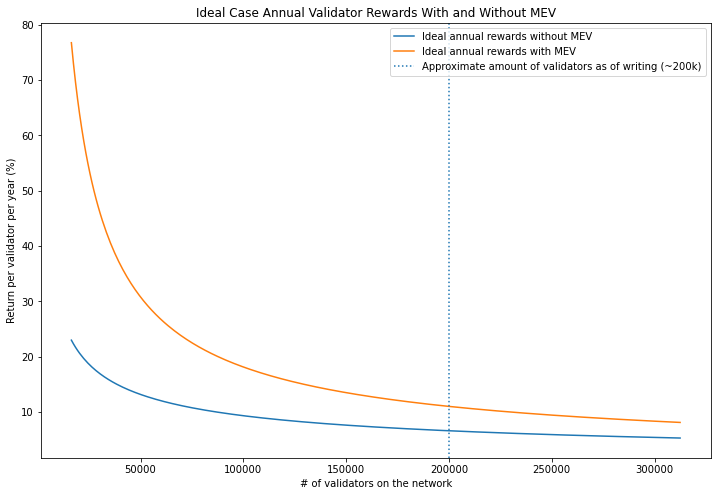

In [2]:
# Ideal, with and without MEV

n_validators = [n for n in range(lower_bound_for_active_staked_eth//32,int(upper_bound_for_active_staked_eth)//32,1000)] # get no of validators for the range 0.5M to 10M staked ETH, 3200 at a time
ideal_reward = [(4 * annualised_base_reward(n)) for n in n_validators]
ideal_reward_with_mev = [(4 * annualised_base_reward(n) +  (avg_mev_reward_per_block * average_blocks_proposed_per_year(n) * (block_selection_frequency_flashbots/100)) ) for n in n_validators]

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot([n for n in n_validators], [100 * r / 32 for r in ideal_reward], label='Ideal annual rewards without MEV')
ax.plot([n for n in n_validators], [100 * r / 32 for r in ideal_reward_with_mev], label='Ideal annual rewards with MEV')
plt.axvline(x=validators_on_the_network_today, linestyle="dotted", label="Approximate amount of validators as of writing (~200k)")
ax.set_xlabel('# of validators on the network')
ax.set_ylabel('Return per validator per year (%)')
ax.set_title('Ideal Case Annual Validator Rewards With and Without MEV')
leg = ax.legend()

In [3]:
# tabulate returns for various amounts of validators with and without MEV
# setup an array of various # of possible active validators
n_validators = [524288 // 32, 50000, 100000, 120000, 150000, 160000, 200000, 250000, 300000, 10000000 // 32]
staked = [32 * n for n in n_validators] # ETH actively staked in the network
ideal_reward = [4 * annualised_base_reward(n) for n in n_validators]
ideal_reward_with_mev = [(4 * annualised_base_reward(n) +  (avg_mev_reward_per_block * average_blocks_proposed_per_year(n)  * (block_selection_frequency_flashbots/100))) for n in n_validators]
annual_yield = [100 * r / 32 for r in ideal_reward]
annual_yield_with_mev = [100 * r / 32 for r in ideal_reward_with_mev]

# calculate percentage increase in annual yield from MEV
percentage_increase_yield = []
for i in range(len(annual_yield)):
    percentage_increase_yield.append((annual_yield_with_mev[i]/annual_yield[i]-1)*100)
    
# calculate reward increase in ETH from MEV
reward_increase = []
for i in range(len(ideal_reward)):
    reward_increase.append(ideal_reward_with_mev[i]-ideal_reward[i])
    
data = {
    '# of validators': n_validators,
    'annual reward (ETH)': ideal_reward,
    'annual reward with mev (ETH)':ideal_reward_with_mev,
    'annual validator yield (%)': annual_yield,
    'annual validator yield with mev (%)': annual_yield_with_mev,
    'annual increase in reward from mev (ETH)': reward_increase,
    'annual increase in yield from mev (%)': percentage_increase_yield,
}

df = pd.DataFrame(data)

pd.options.display.float_format = '{:,.2f}'.format
df.set_index('# of validators')

,annual reward (ETH),annual reward with mev (ETH),annual validator yield (%),annual validator yield with mev (%),annual increase in reward from mev (ETH),annual increase in yield from mev (%)
# of validators,,,,,,
16384,7.35,24.57,22.97,76.79,17.22,234.31
50000,4.21,9.85,13.15,30.78,5.64,134.12
100000,2.98,5.80,9.30,18.12,2.82,94.84
120000,2.72,5.07,8.49,15.84,2.35,86.58
150000,2.43,4.31,7.59,13.47,1.88,77.44
160000,2.35,4.12,7.35,12.86,1.76,74.98
200000,2.10,3.51,6.57,10.98,1.41,67.06
250000,1.88,3.01,5.88,9.41,1.13,59.98
300000,1.72,2.66,5.37,8.31,0.94,54.76


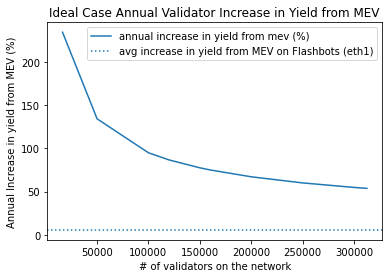

In [4]:
# plot of annual increase in yield from mev in eth2

ax = df.plot('# of validators','annual increase in yield from mev (%)')
ax.axhline(5.6, linestyle="dotted", label="avg increase in yield from MEV on Flashbots (eth1)")
ax.set_xlabel('# of validators on the network')
ax.set_ylabel('Annual Increase in yield from MEV (%)')
ax.set_title('Ideal Case Annual Validator Increase in Yield from MEV')
leg = ax.legend()

for 200 k ~ validators make an additional 1.41 eth per year from MEV revenue
or a 67.06% increase in expected rewards 

### ideal case on 1y timescale
Over any finite timescale, there will be variability in rewards, since some validators will be lucky and be given the opportunity to propose a greater than average number of blocks, and some unlucky, proposing fewer. We can find the distribution of luck for block proposal frequency in a year using the binomial distribution formula:
- every validator has an equal chance of being selected to propose each slot
    - if there are 100,000 validators then the chance of being selected to propose a slot is $10^{-5}$
- there are $\ 31556952 / 12 = 2629746$ slots per year. 

For 100,000 validators, this give us $$P(X) = {{2629746}\choose{k}} \cdot (10^{-5})^k{(1-10^{-5})}^{2629746-k}$$

With 100,000 validators, the mean number of blocks proposed per validator per year is 26.30

The unluckiest 1% of validators will have the opportunity to produce at most 15 blocks in a year
The median (average) validator will have the opportunity to produce 26 blocks in a year
The luckiest 1% of validators will have the opportunity to produce at least 39 blocks in a year


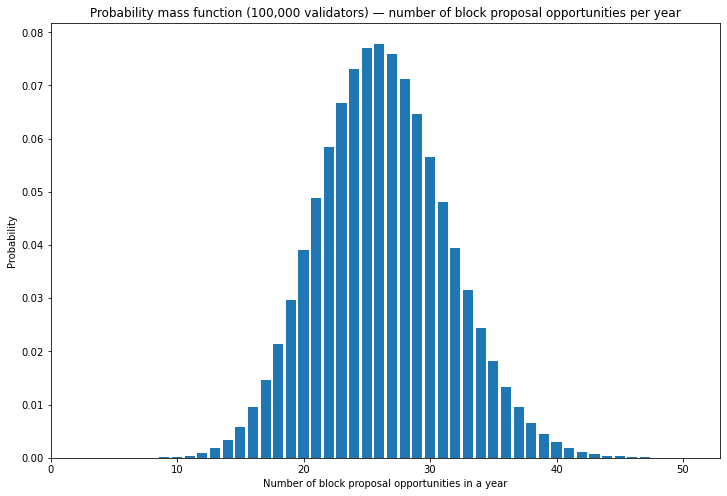

In [5]:
from scipy.stats import binom

x = [el for el in range(51)]
y = binom.pmf(x, 31556952/12, 1e-5)

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(x, y)
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)
ax.set_title('Probability mass function (100,000 validators) — number of block proposal opportunities per year')
ax.set_xlabel('Number of block proposal opportunities in a year')
ax.set_ylabel('Probability')

lmu = binom.ppf([0.01, 0.5, 0.99],31556952/12, 1e-5)
avg = 31556952 / (12 * 100000)
print(f"With 100,000 validators, the mean number of blocks proposed per validator per year is {avg:.2f}\n")
print(f"The unluckiest 1% of validators will have the opportunity to produce at most {int(lmu[0])} blocks in a year")
print(f"The median (average) validator will have the opportunity to produce {int(lmu[1])} blocks in a year")
print(f"The luckiest 1% of validators will have the opportunity to produce at least {int(lmu[2])} blocks in a year")

Repeating the same calculation for different numbers of validators, we obtain the table below for how many blocks the unluckiest 1%, median and luckiest 1% can hope to propose:

In [6]:
# tabulate blocks proposed by unluckiest 1%, median, and luckiest 1% of validators over a year
n_validators = [524288 // 32, 50000, 100000, 120000, 150000, 200000, 250000, 300000, 10000000 // 32]
staked = [32 * n for n in n_validators] # ETH actively staked in the network

data = {
    '# of validators': n_validators,
    'unluckiest 1%': [(binom.ppf(0.01,31556952/12, 1/n)) for n in n_validators],
    'median':[(binom.ppf(0.5,31556952/12, 1/n)) for n in n_validators],
    'luckiest 1%': [(binom.ppf(0.99,31556952/12, 1/n)) for n in n_validators]
}

df = pd.DataFrame(data)

pd.options.display.float_format = '{:,.2f}'.format
df.set_index('# of validators')

,unluckiest 1%,median,luckiest 1%
# of validators,,,
16384,132.00,160.00,191.00
50000,36.00,52.00,70.00
100000,15.00,26.00,39.00
120000,12.00,22.00,33.00
150000,9.00,17.00,28.00
200000,6.00,13.00,22.00
250000,4.00,10.00,19.00
300000,3.00,9.00,16.00
312500,3.00,8.00,16.00


Using these numbers, we can plot maximum validator rewards over a finite timescale and notice how a difference in block-proposal luck influences what the luckiest 1% validators will make in a year, vs the unluckiest 1%.

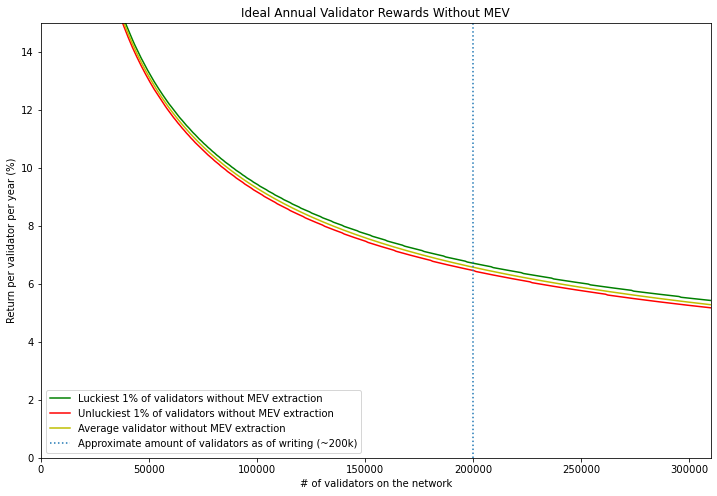

In [7]:
# plot ideal ETH staking return with interpercentile range
# TODO: decide if we want to make it log or not (to show distinction on non-MEV returns)
n_validators = [n for n in range(lower_bound_for_active_staked_eth//32,int(upper_bound_for_active_staked_eth)//32,1000)] # get no of validators for the range 0.5M to 10M staked ETH, 3200 at a time
full_reward = [(4 * annualised_base_reward(n)) for n in n_validators]
attestation_reward = [0.75 * f for f in full_reward]
inclusion_reward = [0.25 * f for f in full_reward]
p = [1/n for n in n_validators]

# calculate lower and upper quartiles for block proposal opportunities
l_bpo = [int(binom.ppf(0.01,31556952/12, 1/n)) for n in n_validators]
mean_bpo = [float(binom.mean(31556952/12, 1/n)) for n in n_validators]
u_bpo = [int(binom.ppf(0.99,31556952/12, 1/n)) for n in n_validators]


full_reward_with_mev = [(4 * annualised_base_reward(n)+ (avg_mev_reward_per_block * average_blocks_proposed_per_year(n) * (block_selection_frequency_flashbots/100))) for n in n_validators] 

# calculate lower and upper quartiles for ideal reward, based on block proposal opportunties
l_reward, u_reward = [], [] # With MEV
for i in range(len(full_reward)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    l_reward.append(r_att + r_inc * ((7/8) + (1/8) * l_bpo[i] / mean_bpo[i]))
    l_reward[i] = l_reward[i] + (l_bpo[i] * avg_mev_reward_per_block * (block_selection_frequency_flashbots/100))
    u_reward.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))
    u_reward[i] = u_reward[i] + (u_bpo[i] * avg_mev_reward_per_block * (block_selection_frequency_flashbots/100))

l_reward_without_mev, u_reward_without_mev = [], []
for i in range(len(full_reward)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    l_reward_without_mev.append(r_att + r_inc * ((7/8) + (1/8) * l_bpo[i] / mean_bpo[i]))
    u_reward_without_mev.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))


fig, ax = plt.subplots(figsize=(12, 8))
# 3rd parameter below sets the color: https://matplotlib.org/stable/tutorials/colors/colors.html
# green => luckiest, red => unluckiest, yellow => average
ax.plot([n for n in n_validators], [100 * r / 32 for r in u_reward_without_mev] , 'g', label='Luckiest 1% of validators without MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in l_reward_without_mev], 'r', label='Unluckiest 1% of validators without MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in full_reward], 'y', label='Average validator without MEV extraction')
ax.set_xlabel('# of validators on the network')
ax.set_ylabel('Return per validator per year (%)')
plt.axvline(x=validators_on_the_network_today, linestyle="dotted", label="Approximate amount of validators as of writing (~200k)")
ax.set_title('Ideal Annual Validator Rewards Without MEV')
# Set limits on X/Y axis
axes = plt.gca()
axes.set_xlim([0,310000]) #min, max
axes.set_ylim([0,15])
leg = ax.legend();

Now overlaying MEV rewards on top:

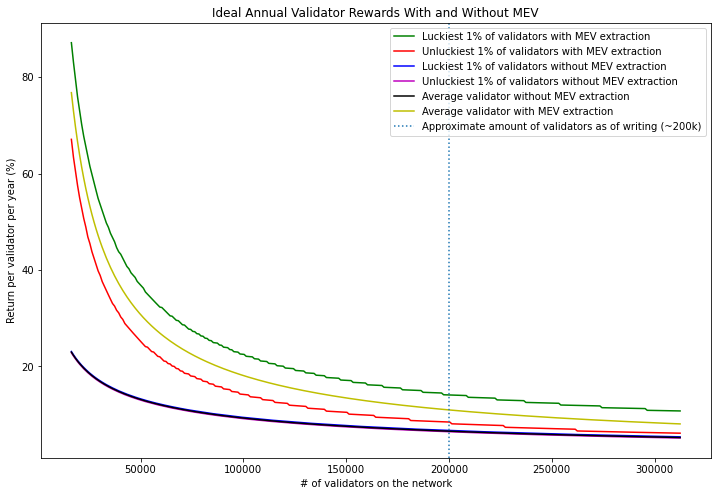

In [8]:
# plot ideal ETH staking return with interpercentile range
# TODO: decide if we want to make it log or not (to show distinction on non-MEV returns)
n_validators = [n for n in range(lower_bound_for_active_staked_eth//32,int(upper_bound_for_active_staked_eth)//32,1000)] # get no of validators for the range 0.5M to 10M staked ETH, 3200 at a time
full_reward = [(4 * annualised_base_reward(n)) for n in n_validators]
attestation_reward = [0.75 * f for f in full_reward]
inclusion_reward = [0.25 * f for f in full_reward]
p = [1/n for n in n_validators]

# calculate lower and upper quartiles for block proposal opportunities
l_bpo = [int(binom.ppf(0.01,31556952/12, 1/n)) for n in n_validators]
mean_bpo = [float(binom.mean(31556952/12, 1/n)) for n in n_validators]
u_bpo = [int(binom.ppf(0.99,31556952/12, 1/n)) for n in n_validators]


full_reward_with_mev = [(4 * annualised_base_reward(n)+ (avg_mev_reward_per_block * average_blocks_proposed_per_year(n) * (block_selection_frequency_flashbots/100))) for n in n_validators] 

# calculate lower and upper quartiles for ideal reward, based on block proposal opportunties
l_reward, u_reward = [], [] # With MEV
for i in range(len(full_reward)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    l_reward.append(r_att + r_inc * ((7/8) + (1/8) * l_bpo[i] / mean_bpo[i]))
    l_reward[i] = l_reward[i] + (l_bpo[i] * avg_mev_reward_per_block * (block_selection_frequency_flashbots/100))
    u_reward.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))
    u_reward[i] = u_reward[i] + (u_bpo[i] * avg_mev_reward_per_block * (block_selection_frequency_flashbots/100))

l_reward_without_mev, u_reward_without_mev = [], []
for i in range(len(full_reward)):
    r_att = attestation_reward[i]
    r_inc = inclusion_reward[i]
    l_reward_without_mev.append(r_att + r_inc * ((7/8) + (1/8) * l_bpo[i] / mean_bpo[i]))
    u_reward_without_mev.append(r_att + r_inc * ((7/8) + (1/8) * u_bpo[i] / mean_bpo[i]))


fig, ax = plt.subplots(figsize=(12, 8))

ax.plot([n for n in n_validators], [100 * r / 32 for r in u_reward] , 'g', label='Luckiest 1% of validators with MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in l_reward], 'r', label='Unluckiest 1% of validators with MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in u_reward_without_mev] , 'b', label='Luckiest 1% of validators without MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in l_reward_without_mev], 'm', label='Unluckiest 1% of validators without MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in full_reward], 'k', label='Average validator without MEV extraction')
ax.plot([n for n in n_validators], [100 * r / 32 for r in full_reward_with_mev], 'y', label='Average validator with MEV extraction')
ax.set_xlabel('# of validators on the network')
ax.set_ylabel('Return per validator per year (%)')
plt.axvline(x=validators_on_the_network_today, linestyle="dotted", label="Approximate amount of validators as of writing (~200k)")
ax.set_title('Ideal Annual Validator Rewards With and Without MEV')
#ax.set_yscale("log")
# Set limits on X/Y axis
leg = ax.legend();

MEV rewards, and its uneven distribution, amplifies the inequality between luckiest and unluckiest validators with respect to block proposal luck.